In [2]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import nest
import itertools
from .utils.inputs import generate_piecewise_constant_signal
import seaborn as sns

ModuleNotFoundError: No module named 'nest'

In [2]:
class BrunelNetwork:
    def __init__(self, g, eta, w, neuron_params, NE, NI,CE,CI,NrE, NrI, rec_start, rec_stop):
        self.num_ex = NE  # number of excitatory neurons
        self.num_in = NI  # number of inhibitory neurons
        self.c_ex = CE  # number of excitatory connections
        self.c_in = CI  # number of inhibitory connections
        self.w = w  # excitatory weight
        # self.J_in = -g*J  # inhibitory weight
        self.n_rec_ex = NrE # number of recorded excitatory neurons, both excitatory and inhibitory
        self.n_rec_in = NrI # number of recorded excitatory neurons, both excitatory and inhibitory
        self.rec_start = rec_start
        self.rec_stop = rec_stop
        self.neuron_params = neuron_params  # neuron params
        self.ext_rate = (self.neuron_params['V_th'] 
                         / (0.1 * self.c_ex * self.neuron_params['tau_m'])
                         * eta * 1000. * self.c_ex)
        
    def create(self):
        # Create the network
        
        # First create the neurons
        self.neurons_ex = nest.Create('iaf_psc_delta', self.num_ex, params=self.neuron_params)
        self.neurons_in = nest.Create('iaf_psc_delta', self.num_in, params=self.neuron_params)
        
        self.neurons = self.neurons_ex + self.neurons_in
        
        # Then create the external spike generator
        self.poisson_noise = nest.Create('poisson_generator', params={'rate': self.ext_rate})
        
        # Then create spike detectors
        self.detector_ex = nest.Create('spike_recorder',
                                       self.n_rec_ex,
                                       params={'start' : self.rec_start, 'stop': self.rec_stop})
        self.detector_in = nest.Create('spike_recorder',
                                       self.n_rec_in,
                                       params={'start': self.rec_start, 'stop': self.rec_stop})
        
        
        # Next we connect the neurons
        # Iterate by row in w
        for i_row in range(self.num_ex):
            #TODO for the target neurons, select only the guys with a nonzero weight, otherwise
            # you create a fully connected matrix with a bunch of 0 weights .. inefficient
            nest.Connect(self.neurons_ex[i_row], self.neurons_ex,
                        conn_spec = {'rule': 'all_to_all'},
                        syn_spec = {'synapse_model': 'static_synapse',
                                    'delay': 1.5,
                                    'weight': self.w[i_row]})
        
        nest.Connect(self.neurons_ex, self.neurons_in,
                     conn_spec = {'rule': 'fixed_indegree',
                                 'indegree': self.c_ex},
                     syn_spec = {'synapse_model': 'static_synapse',
                                 'delay': 1.5,
                                 'weight': self.w[-1,-1]})
        
        
        nest.Connect(self.neurons_in, self.neurons,
                     conn_spec = {'rule': 'fixed_indegree',
                                 'indegree': self.c_in},
                     syn_spec = {'synapse_model': 'static_synapse',
                                 'delay': 1.5,
                                 'weight': self.w[-1,-1]})
        
        # Then we connect the external drive to the neurons
        nest.Connect(self.poisson_noise, self.neurons,
                     syn_spec = {'synapse_model': 'static_synapse',
                                 'delay': 1.5,
                                 'weight': 0.1})
        
        # Then we connect the the neurons to the spike detectors
        nest.Connect(self.neurons_ex[:self.n_rec_ex], self.detector_ex, 'one_to_one')
        nest.Connect(self.neurons_in[:self.n_rec_in], self.detector_in, 'one_to_one')
        
    def simulate(self, t_sim):
        # Simulate the network with specified 
        nest.Simulate(t_sim)
        
    def get_data(self):
        # get spikes from recorders
        spikes_ex = []
        spikes_in = []
        
        for i in range(self.n_rec_ex):
            spikes_ex.append(
                list(np.sort(nest.GetStatus(self.detector_ex)[i]['events']['times'])))
        for i in range(self.n_rec_in):
            spikes_in.append(
                list(np.sort(nest.GetStatus(self.detector_in)[i]['events']['times'])))
            
        return spikes_ex, spikes_in


In [3]:
# Helper function to plot spiking activity
def plot_raster_rate(spikes_ex, spikes_in, rec_start, rec_stop, figsize=(9, 5),save=False):
    
    spikes_ex_total = list(itertools.chain(*spikes_ex))
    spikes_in_total = list(itertools.chain(*spikes_in))
    spikes_total = spikes_ex_total + spikes_in_total
    
    n_rec_ex = len(spikes_ex)
    n_rec_in = len(spikes_in)
    
    fig = plt.figure(constrained_layout=True, figsize=figsize)
    gs = fig.add_gridspec(5, 1)
    
    ax1 = fig.add_subplot(gs[:4,0])
    ax2 = fig.add_subplot(gs[4,0])
    
    ax1.set_xlim([rec_start, rec_stop])
    ax2.set_xlim([rec_start, rec_stop])
    
    ax1.set_ylabel('Neuron ID')
    
    ax2.set_ylabel('Firing rate')
    ax2.set_xlabel('Time [ms]')
    
    
    for i in range(n_rec_in):
        ax1.plot(spikes_in[i],
                 i*np.ones(len(spikes_in[i])),
                 linestyle='',
                 marker='o',
                 color='r',
                 markersize=2)
    for i in range(n_rec_ex):
        ax1.plot(spikes_ex[i],
                 (i + n_rec_in)*np.ones(len(spikes_ex[i])),
                 linestyle='',
                 marker='o',
                 color='b',
                 markersize=2)

        
    ax2 = ax2.hist(spikes_ex_total,
                   range=(rec_start,rec_stop),
                   bins=int(rec_stop - rec_start))
    if save:
        plt.savefig('raster.png')

    time_diff = (rec_stop - rec_start)/1000.
    average_firing_rate = (len(spikes_total)
                           / time_diff
                           /(n_rec_ex + n_rec_in))
    print(f'Average firing rate: {average_firing_rate} Bq')

In [4]:
seed = 1
np.random.seed(seed)

In [5]:
# network parameters
gamma = 0.25               # relative number of inhibitory connections
NE = 999                  # number of excitatory neurons (10.000 in [1])
NI = int(gamma * NE)       # number of inhibitory neurons
CE = 100                   # indegree from excitatory neurons
CI = int(gamma * CE)  
Ntotal=NE+NI
# synapse parameters
# w = 0.1                    # excitatory synaptic weight (mV)
# w *= np.sqrt(10)
g = 5.                     # relative inhibitory to excitatory synaptic weight
d = 1.5                    # synaptic transmission delay (ms)
# Define J matrix
w_ex_in = 0.1
w_ex_out = 0.1
wc = [w_ex_in, 2*w_ex_in, 3*w_ex_in]
w_ex = np.full((NE,NE),w_ex_in,dtype=np.float64)
n_clusters = 3
nn_c = int(NE/n_clusters)
for i_n in range(n_clusters):
    st=i_n*nn_c
    end=(i_n+1)*nn_c
    w_ex[st:end,st:end] = wc[i_n]
wi = np.full((NI,NE),-w_ex_in*g)
w=np.concatenate((w_ex,wi),axis=0)

# neuron paramters
V_th = 20.                 # spike threshold (mV)
tau_m = 20.                # membrane time constant (ms)
neuron_params = {
    'C_m': 1.0,            # membrane capacity (pF)
    'E_L': 0.,             # resting membrane potential (mV)
    'I_e': 0.,             # external input current (pA)
    'V_m': 0.,             # membrane potential (mV)
    'V_reset': 10.,        # reset membrane potential after a spike (mV)
    'V_th': V_th,          #
    't_ref': 2.0,          # refractory period (ms)
    'tau_m': tau_m,        #
}
params = {'g':g, 
          'eta':2.0,#set external rate above threshold, 
          'w':w, 
          'neuron_params':neuron_params,    
          'NE':NE,
          'NI':NI,
          'CE':CE,
          'CI':CI, 
          'NrE':NE, 
          'NrI':NI, 
          'rec_start':0, 
          'rec_stop':1000,
    
}

<Axes: >

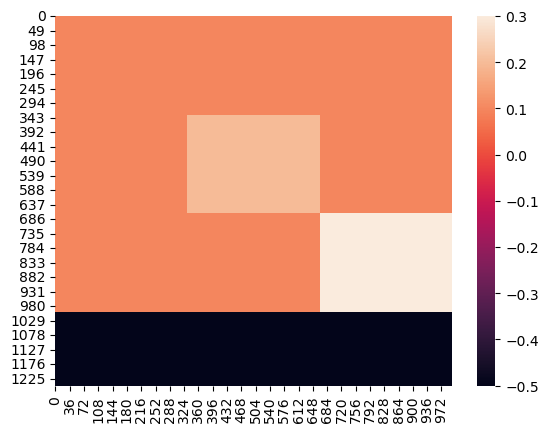

In [6]:
sns.heatmap(w)


Oct 18 16:13:18 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 18 16:23:40 NodeManager::prepare_nodes [Info]: 
    Preparing 11240 nodes for simulation.

Oct 18 16:23:42 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 11240
    Simulation time (ms): 800
    Number of OpenMP threads: 8
    Not using MPI

[ 100% ] Model time: 800.0 ms, Real-time factor: 159.6204

Oct 18 16:25:50 SimulationManager::run [Info]: 
    Simulation finished.
Average firing rate: 280.1955128205128 Bq


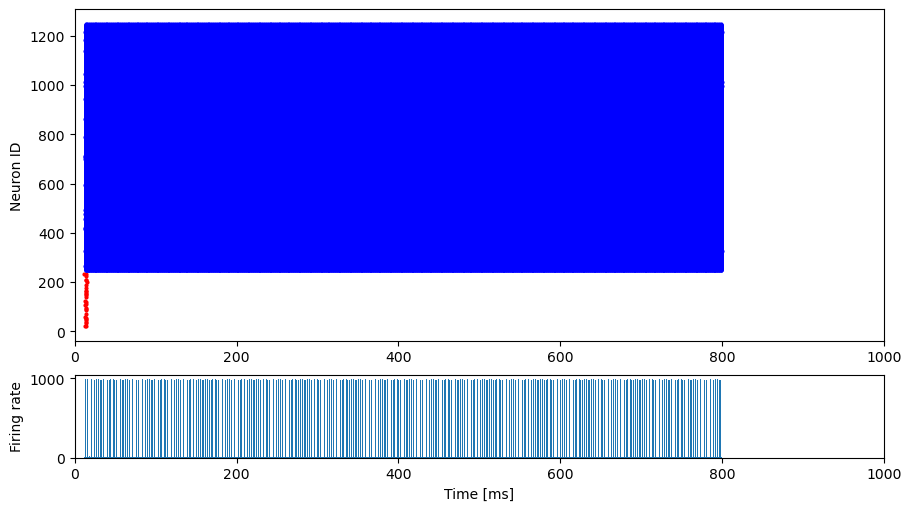

In [7]:
dt = 0.1  # simulation resolution
sim_time = 1000. # simulation time [ms] (for each epoch)
num_threads = 8
nest.ResetKernel()
nest.SetKernelStatus({
    'rng_seed': seed,
    'resolution': dt,
    'print_time': True,
    'local_num_threads': num_threads})


network = BrunelNetwork(**params)

network.create()
network.simulate(sim_time)
spikes_ex, spikes_in = network.get_data()
plot_raster_rate(spikes_ex, spikes_in, params['rec_start'], params['rec_stop'])